<a href="https://colab.research.google.com/github/IronAvenger11-prog/Robot-Localization-with-Python-and-Particle-Filters/blob/main/robot_mark2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Robot Localization with Python and Particle Filters
===================================================

Import libraries and load map.

In [1]:
!pip install opencv-python

In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

map = cv2.imread("map.png",0)
HEIGHT, WIDTH = map.shape
print(map)

rx, ry, rtheta = (WIDTH/4, HEIGHT/4, 0)

[[ 79  80  82 ... 133 148 156]
 [ 78  79  81 ... 138 156 164]
 [ 76  77  79 ... 147 170 180]
 ...
 [181 181 182 ... 174 172 171]
 [178 178 178 ... 180 179 178]
 [177 177 177 ... 183 182 182]]


Map coordinate system

![title](https://github.com/IronAvenger11-prog/Robot-Localization-with-Python-and-Particle-Filters/blob/main/images/coords.png?raw=1)

CAUTION: The terrain height at X,Y coordinates is map(Y,X).

Read keyboard input.

In [4]:
STEP = 5
TURN = np.radians(25)

def get_input():
  fwd = 8
  turn = 0
  halt = False
  k = cv2.waitKey(0)
  if k == 82:
    fwd = STEP
  elif k == 83:
    turn = TURN
  elif k == 81:
    turn = -TURN
  else:
    halt = True

  return fwd, turn, halt

Move the robot, with Gausssian noise.

![title](https://github.com/IronAvenger11-prog/Robot-Localization-with-Python-and-Particle-Filters/blob/main/images/gaussian.png?raw=1)

In [5]:
SIGMA_STEP = 0.5
SIGMA_TURN = np.radians(5)

def move_robot(rx, ry, rtheta, fwd, turn):
  fwd_noisy = np.random.normal(fwd, SIGMA_STEP, 1)
  rx += fwd_noisy*np.cos(rtheta)
  ry += fwd_noisy*np.sin(rtheta)
  print("fwd_noisy = ",fwd_noisy)

  turn_noisy = np.random.normal(turn, SIGMA_TURN, 1)
  rtheta += turn_noisy
  print("turn_noisy = ", np.degrees(turn_noisy))

Initialize particle cloud.

In [6]:
NUM_PARTICLES = 3000
def init():
  particles = np.random.rand(NUM_PARTICLES, 3)
  particles += np.array([WIDTH, HEIGHT, np.radians(360)])
  return ()

Move the particles.

In [7]:
def move_particles(particles, fwd, turn):
  particles[:,0] += fwd*np.cos(particles[:,2])
  particles[:,1] += fwd*np.sin(particles[:,2])
  particles[:,2] += turn

  particles[:,0] = np.clip(particles[:,0], 0.0, WIDTH-1)
  particles[:,1] = np.clip(particles[:,1], 0.0, HEIGHT-1)
  return particles

Get value from robot's sensor.

In [8]:
SIGMA_SENSOR = 2
def sense(x, y, noisy=False):
  x = int(x)
  y = int(y)
  if noisy:
    return np.random.normal(map[y,x], SIGMA_SENSOR, 1)

  return map[y,x]

Compute particle weights.

In [10]:
def compute_weights(particles, robot_sensor):
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        elevation = sense(particles[i,0], particles[i,1], noisy=False)
        errors[i] = abs(robot_sensor - elevation)
    weights = np.max(errors) - errors
    weights[(particles[:,0] == 0)  |
            (particles[:,0] == WIDTH-1)  |
            (particles[:,1] == 0)  |
            (particles[:,1] == HEIGHT-1)] = 0
    weights = weights**3
    return weights


Resample the particles.

In [12]:
def resample(particles, weights):
  probabilities = weights/np.sum(weights)
  new_index = np.random.choice(
      NUM_PARTICLES,
      size = NUM_PARTICLES,
      p = probabilities
  )
  particles = particles[new_index,:]

  return particles

Add noise to the particles.

In [13]:
SIGMA_POS = 2
SIGMA_TURN = np.radians(10)
def add_noise(particles):
  noise = np.concatenate(
      (

          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_TURN, (NUM_PARTICLES, 1))
      ),
      axis = 1
      )
  particles += noise
  return particles

Display robot, particles and best guess.

In [16]:
def display(map, rx, ry, particles):
    lmap = cv2.cvtColor(map, cv2.COLOR_GRAY2BGR)

    # Display particles
    if len(particles) > 0:
        for i in range(NUM_PARTICLES):
            cv2.circle(lmap,
                       (int(particles[i,0]), int(particles[i,1])),
                       1,
                       (255,0,0),
                       1)

    # Display robot
    cv2.circle(lmap, (int(rx), int(ry)), 5, (0,255,0), 10)

    # Display best guess
    if len(particles) > 0:
        px = np.mean(particles[:,0])
        py = np.mean(particles[:,1])
        cv2.circle(lmap, (int(px), int(py)), 5, (0,0,255), 5)

    cv2_imshow(lmap)


Main routine.

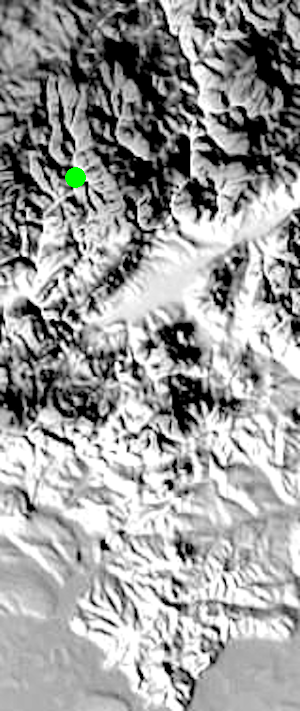

In [19]:


rx_history = []
ry_history = []

particles = init()
while True:
    display(map, rx, ry, particles)
    fwd, turn, halt = get_input()
    if halt:
        break
    rx, ry, rtheta = move_robot(rx, ry, rtheta, fwd, turn)
    particles = move_particles(particles, fwd, turn)
    rx_history.append(rx)
    ry_history.append(ry)
    if fwd != 0:
        robot_sensor = sense(rx, ry, noisy=True)
        weights = compute_weights(particles, robot_sensor)
        particles = resample(particles, weights)
        particles = add_noise(particles)



In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

map = cv2.imread("map.png",0)
HEIGHT, WIDTH = map.shape
print(map)

rx, ry, rtheta = (WIDTH/4, HEIGHT/4, 0)

STEP = 5
TURN = np.radians(25)

def get_input():
  fwd = 8
  turn = 0
  halt = False
  k = cv2.waitKey(0)
  if k == 82:
    fwd = STEP
  elif k == 83:
    turn = TURN
  elif k == 81:
    turn = -TURN
  else:
    halt = True

  return fwd, turn, halt

  SIGMA_STEP = 0.5
SIGMA_TURN = np.radians(5)

def move_robot(rx, ry, rtheta, fwd, turn):
  fwd_noisy = np.random.normal(fwd, SIGMA_STEP, 1)
  rx += fwd_noisy*np.cos(rtheta)
  ry += fwd_noisy*np.sin(rtheta)
  print("fwd_noisy = ",fwd_noisy)

  turn_noisy = np.random.normal(turn, SIGMA_TURN, 1)
  rtheta += turn_noisy
  print("turn_noisy = ", np.degrees(turn_noisy))

  STEP = 5
TURN = np.radians(25)

def get_input():
  fwd = 8
  turn = 0
  halt = False
  k = cv2.waitKey(0)
  if k == 82:
    fwd = STEP
  elif k == 83:
    turn = TURN
  elif k == 81:
    turn = -TURN
  else:
    halt = True

  return fwd, turn, halt

  SIGMA_STEP = 0.5
SIGMA_TURN = np.radians(5)

def move_robot(rx, ry, rtheta, fwd, turn):
  fwd_noisy = np.random.normal(fwd, SIGMA_STEP, 1)
  rx += fwd_noisy*np.cos(rtheta)
  ry += fwd_noisy*np.sin(rtheta)
  print("fwd_noisy = ",fwd_noisy)

  turn_noisy = np.random.normal(turn, SIGMA_TURN, 1)
  rtheta += turn_noisy
  print("turn_noisy = ", np.degrees(turn_noisy))


  NUM_PARTICLES = 3000
def init():
  particles = np.random.rand(NUM_PARTICLES, 3)
  particles += np.array([WIDTH, HEIGHT, np.radians(360)])
  return ()

  def move_particles(particles, fwd, turn):
  particles[:,0] += fwd*np.cos(particles[:,2])
  particles[:,1] += fwd*np.sin(particles[:,2])
  particles[:,2] += turn

  particles[:,0] = np.clip(particles[:,0], 0.0, WIDTH-1)
  particles[:,1] = np.clip(particles[:,1], 0.0, HEIGHT-1)
  return particles

  SIGMA_SENSOR = 2
def sense(x, y, noisy=False):
  x = int(x)
  y = int(y)
  if noisy:
    return np.random.normal(map[y,x], SIGMA_SENSOR, 1)

  return map[y,x]


  def compute_weights(particles, robot_sensor):
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        elevation = sense(particles[i,0], particles[i,1], noisy=False)
        errors[i] = abs(robot_sensor - elevation)
    weights = np.max(errors) - errors
    weights[(particles[:,0] == 0)  |
            (particles[:,0] == WIDTH-1)  |
            (particles[:,1] == 0)  |
            (particles[:,1] == HEIGHT-1)] = 0
    weights = weights**3
    return weights


def resample(particles, weights):
  probabilities = weights/np.sum(weights)
  new_index = np.random.choice(
      NUM_PARTICLES,
      size = NUM_PARTICLES,
      p = probabilities
  )
  particles = particles[new_index,:]

  return particles


SIGMA_POS = 2
SIGMA_TURN = np.radians(10)
def add_noise(particles):
  noise = np.concatenate(
      (

          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_TURN, (NUM_PARTICLES, 1))
      ),
      axis = 1
      )
  particles += noise
  return particles

def display(map, rx, ry, particles):
    lmap = cv2.cvtColor(map, cv2.COLOR_GRAY2BGR)

    # Display particles
    if len(particles) > 0:
        for i in range(NUM_PARTICLES):
            cv2.circle(lmap,
                       (int(particles[i,0]), int(particles[i,1])),
                       1,
                       (255,0,0),
                       1)

    # Display robot
    cv2.circle(lmap, (int(rx), int(ry)), 5, (0,255,0), 10)

    # Display best guess
    if len(particles) > 0:
        px = np.mean(particles[:,0])
        py = np.mean(particles[:,1])
        cv2.circle(lmap, (int(px), int(py)), 5, (0,0,255), 5)

    cv2_imshow(lmap)

particles = init()
while True:
    display(map, rx, ry, particles)
    fwd, turn, halt = get_input()
    if halt:
        break
    rx, ry, rtheta = move_robot(rx, ry, rtheta, fwd, turn)
    particles = move_particles(particles, fwd, turn)
    if fwd != 0:
        robot_sensor = sense(rx, ry, noisy=True)
        weights = compute_weights(particles, robot_sensor)
        particles = resample(particles, weights)
        particles = add_noise(particles)

cv2.destroyAllWindows()


In [20]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Ensure plots are displayed within the notebook
%matplotlib inline
def animate_particles(frames):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, WIDTH)
    ax.set_ylim(0, HEIGHT)
    lmap = ax.imshow(map, cmap='gray', origin='upper')

    def update(frame):
        ax.clear()
        ax.imshow(map, cmap='gray', origin='upper')
        ax.scatter(particles[frame][:, 0], particles[frame][:, 1], c='red', s=2)
        ax.plot(rx_history[:frame+1], ry_history[:frame+1], c='blue')
        ax.plot([rx_history[frame]], [ry_history[frame]], marker='o', markersize=8, c='green')
        ax.set_title(f"Frame {frame+1}/{len(particles)}")

    ani = FuncAnimation(fig, update, frames=len(particles), repeat=False)
    plt.close()
    return ani

# Create animation
animation = animate_particles(len(particles))
HTML(animation.to_jshtml())
animation.save('particle_filter_animation.mp4', writer='ffmpeg')



/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:1740: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:1740: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


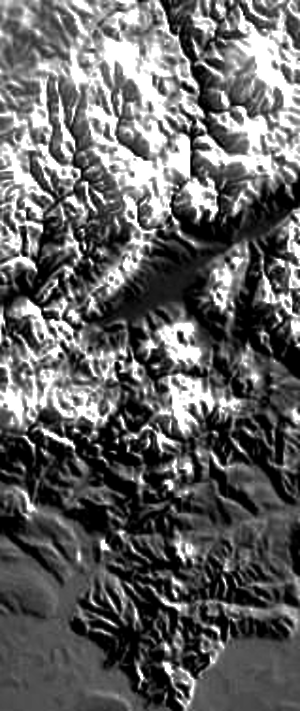

In [25]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

terrain_image = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE)
depth_map = (255 - terrain_image) / 255.0  # Invert image and normalize

cv2_imshow((depth_map * 255).astype(np.uint8))



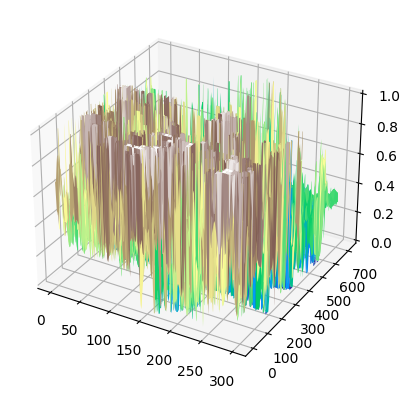

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(np.arange(terrain_image.shape[1]), np.arange(terrain_image.shape[0]))
Z = depth_map

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='terrain')
plt.show()


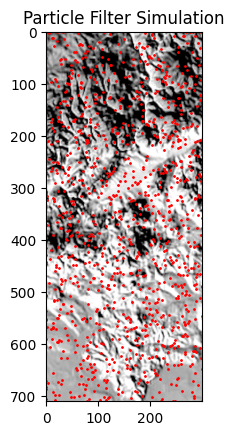

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Load terrain map image
terrain_image = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE)

# Particle filter parameters
NUM_PARTICLES = 1000

def init_particles():
    particles = np.random.rand(NUM_PARTICLES, 2)
    particles[:, 0] *= terrain_image.shape[1]  # X coordinate
    particles[:, 1] *= terrain_image.shape[0]  # Y coordinate
    return particles

def move_particles(particles, movement_noise=10):
    particles += np.random.normal(0, movement_noise, particles.shape)
    particles[:, 0] = np.clip(particles[:, 0], 0, terrain_image.shape[1] - 1)
    particles[:, 1] = np.clip(particles[:, 1], 0, terrain_image.shape[0] - 1)
    return particles

# Initialize particles
particles = init_particles()

# Simulate movement and resampling
for t in range(50):  # Change the number of time steps as needed
    particles = move_particles(particles)

# Display particles on terrain map
plt.imshow(terrain_image, cmap="gray")
plt.scatter(particles[:, 0], particles[:, 1], c="red", s=1)
plt.title("Particle Filter Simulation")
plt.show()


In [43]:
!pip install scikit-robot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.9 MB/s eta 0:00:00
  Created wheel for scikit-robot: filename=scikit_robot-0.0.30-py3-none-any.whl size=730253 sha256=8bdc0be740990ca7618bd9350454d7e2936775c47399f7917b2a4bf571909b8e
  Stored in directory: /root/.cache/pip/wheels/44/93/d1/276238eb39aa96a

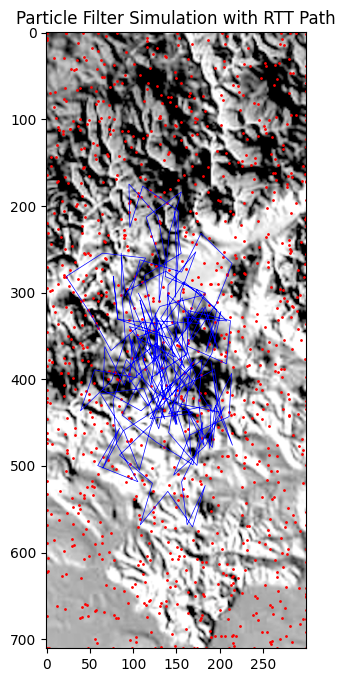

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from google.colab import widgets

# Load terrain map image
terrain_image = plt.imread("map.png")

# Particle filter parameters
NUM_PARTICLES = 1000

def init_particles():
    particles = np.random.rand(NUM_PARTICLES, 2)
    particles[:, 0] *= terrain_image.shape[1]  # X coordinate
    particles[:, 1] *= terrain_image.shape[0]  # Y coordinate
    return particles

def move_particles(particles, movement_noise=10):
    particles += np.random.normal(0, movement_noise, particles.shape)
    particles[:, 0] = np.clip(particles[:, 0], 0, terrain_image.shape[1] - 1)
    particles[:, 1] = np.clip(particles[:, 1], 0, terrain_image.shape[0] - 1)
    return particles

# RTT path generation
def rtt_path(particles, num_iterations=100, radius=50):
    path = []
    curr_position = np.mean(particles, axis=0)
    path.append(curr_position)

    for _ in range(num_iterations):
        random_particle = particles[np.random.choice(NUM_PARTICLES)]
        diff = random_particle - curr_position
        new_position = curr_position + (diff / np.linalg.norm(diff)) * radius
        new_position = np.clip(new_position, [0, 0], [terrain_image.shape[1] - 1, terrain_image.shape[0] - 1])
        path.append(new_position)
        curr_position = new_position

    return np.array(path)

# Initialize particles
particles = init_particles()

# Simulate movement
for t in range(50):  # Change the number of time steps as needed
    particles = move_particles(particles)

# Generate RTT path
path = rtt_path(particles, num_iterations=200, radius=50)

# Display particles and RTT path on terrain map
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(terrain_image, cmap="gray")
ax.scatter(particles[:, 0], particles[:, 1], c="red", s=1)
ax.plot(path[:, 0], path[:, 1], c="blue", linewidth=0.5)
ax.set_title("Particle Filter Simulation with RTT Path")
plt.show()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Load terrain map image
terrain_image = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE)

# Particle filter parameters
NUM_PARTICLES = 1000

def init_particles():
    particles = np.random.rand(NUM_PARTICLES, 2)
    particles[:, 0] *= terrain_image.shape[1]  # X coordinate
    particles[:, 1] *= terrain_image.shape[0]  # Y coordinate
    return particles

def move_particles(particles, movement_noise=10):
    particles += np.random.normal(0, movement_noise, particles.shape)
    particles[:, 0] = np.clip(particles[:, 0], 0, terrain_image.shape[1] - 1)
    particles[:, 1] = np.clip(particles[:, 1], 0, terrain_image.shape[0] - 1)
    return particles

def get_depth_value(point):
    x, y = point
    return terrain_image[y, x]

def heuristic_cost(point, goal):
    return np.linalg.norm(point - goal)

def a_star_path(start, end):
    open_list = [start]
    came_from = {}
    g_score = {tuple(point): float("inf") for point in np.ndindex(terrain_image.shape[:2])}
    g_score[tuple(start)] = 0

    while open_list:
        current = min(open_list, key=lambda p: g_score[tuple(p)] + heuristic_cost(p, end))
        open_list.remove(current)

        if tuple(current) == tuple(end):
            break

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                neighbor = (current[0] + dx, current[1] + dy)
                if 0 <= neighbor[0] < terrain_image.shape[1] and 0 <= neighbor[1] < terrain_image.shape[0]:
                    tentative_g_score = g_score[tuple(current)] + get_depth_value(neighbor)
                    if tentative_g_score < g_score.get(tuple(neighbor), float("inf")):
                        came_from[tuple(neighbor)] = current
                        g_score[tuple(neighbor)] = tentative_g_score
                        if neighbor not in open_list:
                            open_list.append(neighbor)

    path = []
    current = end
    while current != start:
        path.append(current)
        current = came_from[tuple(current)]
    path.append(start)
    return np.array(path[::-1])

# Define start and end positions
start = np.array([50, 50])  # Adjust coordinates as needed
end = np.array([200, 200])  # Adjust coordinates as needed

# Generate path using A* algorithm
a_star_generated_path = a_star_path(start, end)

# Initialize particles
particles = init_particles()

# Simulate movement and adjust path using particles
adjusted_path = []
for i in range(len(a_star_generated_path)):
    particles = move_particles(particles)
    avg_position = np.mean(particles, axis=0)
    adjusted_path.append(avg_position)

# Convert adjusted path to numpy array
adjusted_path = np.array(adjusted_path)

# Display terrain map with adjusted path
plt.imshow(terrain_image, cmap="gray")
plt.plot(adjusted_path[:, 0], adjusted_path[:, 1], c="blue")  # Connect points with a line
plt.title("Curved Path using A* and Particle Filters")
plt.show()

